In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 64

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 128)  3456        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 128)  18816       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 128)  512         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 128)    147456      spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 128)    512         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 128)    0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 128)    0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 128)          0           spatial_dropout2d_9[0][0]        
__________

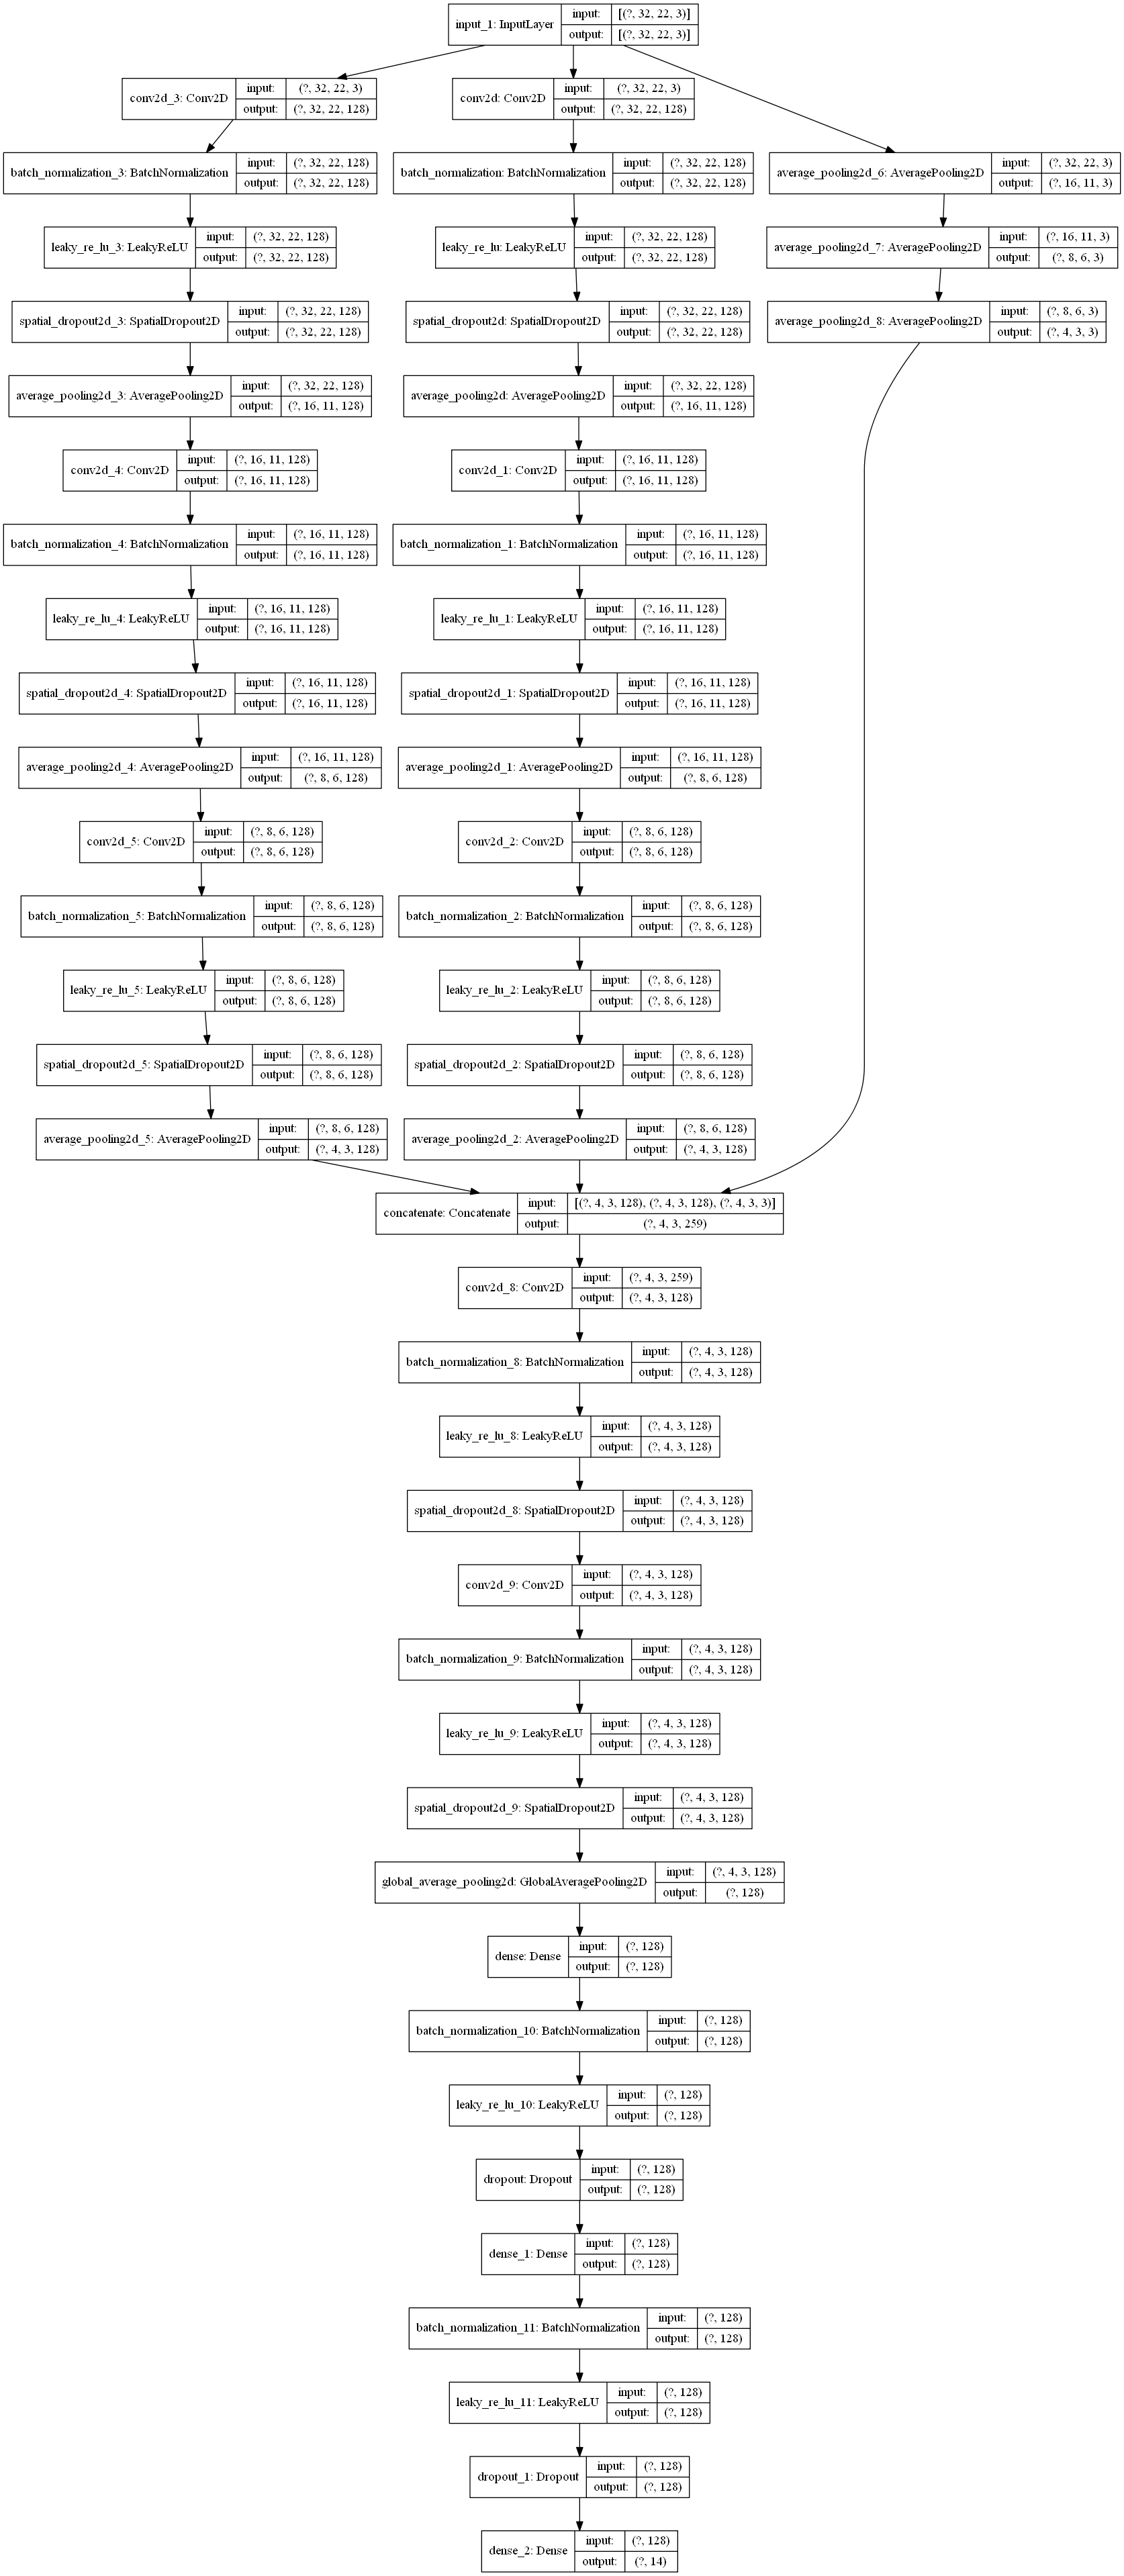

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|▊                                                                              | 21/1960 [00:00<00:09, 204.74it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 208.02it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:03<00:00, 211.15it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:53 - loss: 3.2846 - acc: 0.0000e+0 - ETA: 1:04 - loss: 2.9332 - acc: 0.0781    - ETA: 47s - loss: 2.6896 - acc: 0.156 - ETA: 39s - loss: 2.5140 - acc: 0.19 - ETA: 33s - loss: 2.4245 - acc: 0.23 - ETA: 30s - loss: 2.2961 - acc: 0.26 - ETA: 27s - loss: 2.2330 - acc: 0.27 - ETA: 25s - loss: 2.1910 - acc: 0.28 - ETA: 23s - loss: 2.1538 - acc: 0.30 - ETA: 22s - loss: 2.1050 - acc: 0.31 - ETA: 20s - loss: 2.0597 - acc: 0.32 - ETA: 19s - loss: 2.0263 - acc: 0.33 - ETA: 19s - loss: 1.9792 - acc: 0.35 - ETA: 18s - loss: 1.9629 - acc: 0.36 - ETA: 17s - loss: 1.9449 - acc: 0.36 - ETA: 16s - loss: 1.9058 - acc: 0.37 - ETA: 16s - loss: 1.8756 - acc: 0.38 - ETA: 15s - loss: 1.8468 - acc: 0.39 - ETA: 14s - loss: 1.8035 - acc: 0.40 - ETA: 14s - loss: 1.7788 - acc: 0.41 - ETA: 13s - loss: 1.7487 - acc: 0.42 - ETA: 13s - loss: 1.7290 - acc: 0.43 - ETA: 12s - loss: 1.7155 - acc: 0.43 - ETA: 12

1952/1960 [============================>.] - ETA: 15s - loss: 0.4397 - acc: 0.87 - ETA: 15s - loss: 0.4037 - acc: 0.89 - ETA: 14s - loss: 0.4359 - acc: 0.89 - ETA: 14s - loss: 0.4339 - acc: 0.89 - ETA: 14s - loss: 0.4369 - acc: 0.88 - ETA: 14s - loss: 0.4488 - acc: 0.88 - ETA: 13s - loss: 0.4362 - acc: 0.89 - ETA: 13s - loss: 0.4410 - acc: 0.89 - ETA: 13s - loss: 0.4395 - acc: 0.88 - ETA: 13s - loss: 0.4146 - acc: 0.89 - ETA: 12s - loss: 0.3996 - acc: 0.89 - ETA: 12s - loss: 0.4184 - acc: 0.88 - ETA: 12s - loss: 0.4406 - acc: 0.88 - ETA: 12s - loss: 0.4465 - acc: 0.87 - ETA: 11s - loss: 0.4425 - acc: 0.88 - ETA: 11s - loss: 0.4464 - acc: 0.87 - ETA: 11s - loss: 0.4397 - acc: 0.87 - ETA: 11s - loss: 0.4254 - acc: 0.88 - ETA: 10s - loss: 0.4223 - acc: 0.88 - ETA: 10s - loss: 0.4262 - acc: 0.88 - ETA: 10s - loss: 0.4178 - acc: 0.88 - ETA: 10s - loss: 0.4174 - acc: 0.88 - ETA: 9s - loss: 0.4114 - acc: 0.8872 - ETA: 9s - loss: 0.4147 - acc: 0.885 - ETA: 9s - loss: 0.4191 - acc: 0.883 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.2316 - acc: 0.93 - ETA: 15s - loss: 0.2605 - acc: 0.92 - ETA: 15s - loss: 0.3523 - acc: 0.90 - ETA: 15s - loss: 0.3383 - acc: 0.89 - ETA: 14s - loss: 0.3707 - acc: 0.87 - ETA: 14s - loss: 0.3494 - acc: 0.87 - ETA: 14s - loss: 0.3632 - acc: 0.87 - ETA: 13s - loss: 0.3915 - acc: 0.85 - ETA: 13s - loss: 0.3661 - acc: 0.86 - ETA: 13s - loss: 0.3586 - acc: 0.86 - ETA: 13s - loss: 0.3727 - acc: 0.86 - ETA: 12s - loss: 0.3606 - acc: 0.86 - ETA: 12s - loss: 0.3595 - acc: 0.87 - ETA: 12s - loss: 0.3845 - acc: 0.86 - ETA: 11s - loss: 0.3742 - acc: 0.87 - ETA: 11s - loss: 0.3807 - acc: 0.87 - ETA: 11s - loss: 0.3851 - acc: 0.86 - ETA: 11s - loss: 0.3674 - acc: 0.87 - ETA: 10s - loss: 0.3574 - acc: 0.87 - ETA: 10s - loss: 0.3616 - acc: 0.87 - ETA: 10s - loss: 0.3625 - acc: 0.87 - ETA: 10s - loss: 0.3601 - acc: 0.87 - ETA: 9s - loss: 0.3599 - acc: 0.8791 - ETA: 9s - loss: 0.3512 - acc: 0.881 - ETA: 9s - loss: 0.3489 - acc: 0.881 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.2450 - acc: 0.87 - ETA: 15s - loss: 0.2194 - acc: 0.90 - ETA: 15s - loss: 0.2272 - acc: 0.89 - ETA: 15s - loss: 0.2507 - acc: 0.90 - ETA: 14s - loss: 0.2536 - acc: 0.90 - ETA: 14s - loss: 0.2606 - acc: 0.90 - ETA: 14s - loss: 0.2556 - acc: 0.91 - ETA: 13s - loss: 0.2377 - acc: 0.91 - ETA: 13s - loss: 0.2352 - acc: 0.92 - ETA: 13s - loss: 0.2295 - acc: 0.92 - ETA: 13s - loss: 0.2243 - acc: 0.92 - ETA: 13s - loss: 0.2198 - acc: 0.93 - ETA: 12s - loss: 0.2229 - acc: 0.93 - ETA: 12s - loss: 0.2332 - acc: 0.93 - ETA: 12s - loss: 0.2513 - acc: 0.92 - ETA: 12s - loss: 0.2632 - acc: 0.92 - ETA: 11s - loss: 0.2528 - acc: 0.92 - ETA: 11s - loss: 0.2485 - acc: 0.93 - ETA: 11s - loss: 0.2544 - acc: 0.92 - ETA: 10s - loss: 0.2577 - acc: 0.92 - ETA: 10s - loss: 0.2696 - acc: 0.92 - ETA: 10s - loss: 0.2682 - acc: 0.92 - ETA: 10s - loss: 0.2697 - acc: 0.92 - ETA: 9s - loss: 0.2706 - acc: 0.9206 - ETA: 9s - loss: 0.2839 - acc: 0.920 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.1661 - acc: 0.93 - ETA: 15s - loss: 0.2596 - acc: 0.90 - ETA: 14s - loss: 0.2335 - acc: 0.92 - ETA: 14s - loss: 0.2250 - acc: 0.92 - ETA: 14s - loss: 0.2013 - acc: 0.93 - ETA: 14s - loss: 0.2081 - acc: 0.93 - ETA: 13s - loss: 0.2101 - acc: 0.92 - ETA: 13s - loss: 0.2141 - acc: 0.92 - ETA: 13s - loss: 0.2225 - acc: 0.91 - ETA: 13s - loss: 0.2205 - acc: 0.91 - ETA: 13s - loss: 0.2277 - acc: 0.91 - ETA: 12s - loss: 0.2350 - acc: 0.91 - ETA: 12s - loss: 0.2439 - acc: 0.91 - ETA: 12s - loss: 0.2359 - acc: 0.91 - ETA: 12s - loss: 0.2444 - acc: 0.91 - ETA: 12s - loss: 0.2425 - acc: 0.91 - ETA: 11s - loss: 0.2339 - acc: 0.91 - ETA: 11s - loss: 0.2396 - acc: 0.91 - ETA: 11s - loss: 0.2460 - acc: 0.91 - ETA: 11s - loss: 0.2376 - acc: 0.91 - ETA: 10s - loss: 0.2487 - acc: 0.91 - ETA: 10s - loss: 0.2405 - acc: 0.91 - ETA: 10s - loss: 0.2356 - acc: 0.91 - ETA: 10s - loss: 0.2345 - acc: 0.92 - ETA: 9s - loss: 0.2312 - acc: 0.9237 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0775 - acc: 0.96 - ETA: 16s - loss: 0.0950 - acc: 0.95 - ETA: 15s - loss: 0.1180 - acc: 0.95 - ETA: 15s - loss: 0.1676 - acc: 0.93 - ETA: 15s - loss: 0.1821 - acc: 0.93 - ETA: 15s - loss: 0.1827 - acc: 0.93 - ETA: 14s - loss: 0.1853 - acc: 0.93 - ETA: 14s - loss: 0.1728 - acc: 0.93 - ETA: 14s - loss: 0.1606 - acc: 0.94 - ETA: 14s - loss: 0.1722 - acc: 0.94 - ETA: 13s - loss: 0.1731 - acc: 0.94 - ETA: 13s - loss: 0.1688 - acc: 0.94 - ETA: 13s - loss: 0.1698 - acc: 0.94 - ETA: 13s - loss: 0.1710 - acc: 0.94 - ETA: 12s - loss: 0.1700 - acc: 0.94 - ETA: 12s - loss: 0.1737 - acc: 0.94 - ETA: 12s - loss: 0.1738 - acc: 0.94 - ETA: 11s - loss: 0.1742 - acc: 0.94 - ETA: 11s - loss: 0.1705 - acc: 0.94 - ETA: 11s - loss: 0.1733 - acc: 0.94 - ETA: 10s - loss: 0.1718 - acc: 0.94 - ETA: 10s - loss: 0.1675 - acc: 0.94 - ETA: 10s - loss: 0.1706 - acc: 0.94 - ETA: 10s - loss: 0.1659 - acc: 0.94 - ETA: 9s - loss: 0.1614 - acc: 0.9475 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.2478 - acc: 0.87 - ETA: 15s - loss: 0.2593 - acc: 0.87 - ETA: 14s - loss: 0.2772 - acc: 0.90 - ETA: 14s - loss: 0.2742 - acc: 0.91 - ETA: 14s - loss: 0.2540 - acc: 0.92 - ETA: 14s - loss: 0.2630 - acc: 0.91 - ETA: 13s - loss: 0.2613 - acc: 0.91 - ETA: 13s - loss: 0.2328 - acc: 0.92 - ETA: 13s - loss: 0.2141 - acc: 0.93 - ETA: 13s - loss: 0.2050 - acc: 0.93 - ETA: 12s - loss: 0.1914 - acc: 0.94 - ETA: 12s - loss: 0.1868 - acc: 0.94 - ETA: 12s - loss: 0.1846 - acc: 0.94 - ETA: 12s - loss: 0.2090 - acc: 0.93 - ETA: 11s - loss: 0.2109 - acc: 0.93 - ETA: 11s - loss: 0.2085 - acc: 0.93 - ETA: 11s - loss: 0.2055 - acc: 0.93 - ETA: 11s - loss: 0.2052 - acc: 0.93 - ETA: 10s - loss: 0.2040 - acc: 0.93 - ETA: 10s - loss: 0.2070 - acc: 0.93 - ETA: 10s - loss: 0.2018 - acc: 0.93 - ETA: 10s - loss: 0.1979 - acc: 0.93 - ETA: 9s - loss: 0.1944 - acc: 0.9389 - ETA: 9s - loss: 0.1918 - acc: 0.938 - ETA: 9s - loss: 0.1898 - acc: 0.937 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.1049 - acc: 0.96 - ETA: 15s - loss: 0.1626 - acc: 0.92 - ETA: 14s - loss: 0.2238 - acc: 0.92 - ETA: 14s - loss: 0.1881 - acc: 0.93 - ETA: 14s - loss: 0.1660 - acc: 0.95 - ETA: 14s - loss: 0.1559 - acc: 0.95 - ETA: 13s - loss: 0.1503 - acc: 0.95 - ETA: 13s - loss: 0.1419 - acc: 0.95 - ETA: 13s - loss: 0.1487 - acc: 0.95 - ETA: 13s - loss: 0.1397 - acc: 0.95 - ETA: 12s - loss: 0.1425 - acc: 0.95 - ETA: 12s - loss: 0.1367 - acc: 0.95 - ETA: 12s - loss: 0.1434 - acc: 0.94 - ETA: 12s - loss: 0.1425 - acc: 0.95 - ETA: 11s - loss: 0.1382 - acc: 0.95 - ETA: 11s - loss: 0.1422 - acc: 0.95 - ETA: 11s - loss: 0.1393 - acc: 0.95 - ETA: 11s - loss: 0.1423 - acc: 0.95 - ETA: 10s - loss: 0.1507 - acc: 0.94 - ETA: 10s - loss: 0.1549 - acc: 0.94 - ETA: 10s - loss: 0.1653 - acc: 0.94 - ETA: 10s - loss: 0.1612 - acc: 0.94 - ETA: 9s - loss: 0.1576 - acc: 0.9470 - ETA: 9s - loss: 0.1558 - acc: 0.946 - ETA: 9s - loss: 0.1558 - acc: 0.947 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.2181 - acc: 0.93 - ETA: 16s - loss: 0.1149 - acc: 0.96 - ETA: 15s - loss: 0.0936 - acc: 0.97 - ETA: 15s - loss: 0.0920 - acc: 0.97 - ETA: 14s - loss: 0.1085 - acc: 0.96 - ETA: 14s - loss: 0.0950 - acc: 0.97 - ETA: 14s - loss: 0.0995 - acc: 0.96 - ETA: 14s - loss: 0.1023 - acc: 0.96 - ETA: 13s - loss: 0.1138 - acc: 0.96 - ETA: 13s - loss: 0.1246 - acc: 0.96 - ETA: 13s - loss: 0.1212 - acc: 0.96 - ETA: 12s - loss: 0.1163 - acc: 0.96 - ETA: 12s - loss: 0.1104 - acc: 0.96 - ETA: 12s - loss: 0.1085 - acc: 0.96 - ETA: 12s - loss: 0.1076 - acc: 0.96 - ETA: 11s - loss: 0.1038 - acc: 0.96 - ETA: 11s - loss: 0.1036 - acc: 0.97 - ETA: 11s - loss: 0.1017 - acc: 0.97 - ETA: 10s - loss: 0.1138 - acc: 0.96 - ETA: 10s - loss: 0.1096 - acc: 0.97 - ETA: 10s - loss: 0.1139 - acc: 0.97 - ETA: 10s - loss: 0.1107 - acc: 0.97 - ETA: 9s - loss: 0.1093 - acc: 0.9715 - ETA: 9s - loss: 0.1070 - acc: 0.971 - ETA: 9s - loss: 0.1180 - acc: 0.968 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.1424 - acc: 0.93 - ETA: 15s - loss: 0.1264 - acc: 0.95 - ETA: 15s - loss: 0.0992 - acc: 0.96 - ETA: 14s - loss: 0.0892 - acc: 0.97 - ETA: 14s - loss: 0.0824 - acc: 0.97 - ETA: 14s - loss: 0.0778 - acc: 0.97 - ETA: 14s - loss: 0.0797 - acc: 0.97 - ETA: 13s - loss: 0.0750 - acc: 0.97 - ETA: 13s - loss: 0.0691 - acc: 0.97 - ETA: 13s - loss: 0.0735 - acc: 0.97 - ETA: 12s - loss: 0.0858 - acc: 0.97 - ETA: 12s - loss: 0.0802 - acc: 0.97 - ETA: 12s - loss: 0.0830 - acc: 0.97 - ETA: 12s - loss: 0.0880 - acc: 0.97 - ETA: 11s - loss: 0.0877 - acc: 0.97 - ETA: 11s - loss: 0.0836 - acc: 0.97 - ETA: 11s - loss: 0.0796 - acc: 0.97 - ETA: 11s - loss: 0.0759 - acc: 0.97 - ETA: 10s - loss: 0.0785 - acc: 0.97 - ETA: 10s - loss: 0.0808 - acc: 0.97 - ETA: 10s - loss: 0.0883 - acc: 0.97 - ETA: 10s - loss: 0.0855 - acc: 0.97 - ETA: 9s - loss: 0.0824 - acc: 0.9742 - ETA: 9s - loss: 0.0821 - acc: 0.972 - ETA: 9s - loss: 0.0854 - acc: 0.972 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0090 - acc: 1.00 - ETA: 14s - loss: 0.0139 - acc: 1.00 - ETA: 14s - loss: 0.0133 - acc: 1.00 - ETA: 14s - loss: 0.0355 - acc: 1.00 - ETA: 14s - loss: 0.0603 - acc: 0.98 - ETA: 13s - loss: 0.0655 - acc: 0.98 - ETA: 13s - loss: 0.0583 - acc: 0.98 - ETA: 13s - loss: 0.0631 - acc: 0.98 - ETA: 13s - loss: 0.0625 - acc: 0.98 - ETA: 13s - loss: 0.0628 - acc: 0.98 - ETA: 13s - loss: 0.0589 - acc: 0.98 - ETA: 12s - loss: 0.0618 - acc: 0.97 - ETA: 12s - loss: 0.0625 - acc: 0.97 - ETA: 12s - loss: 0.0674 - acc: 0.97 - ETA: 12s - loss: 0.0697 - acc: 0.97 - ETA: 11s - loss: 0.0736 - acc: 0.97 - ETA: 11s - loss: 0.0723 - acc: 0.97 - ETA: 11s - loss: 0.0709 - acc: 0.97 - ETA: 11s - loss: 0.0724 - acc: 0.97 - ETA: 10s - loss: 0.0823 - acc: 0.97 - ETA: 10s - loss: 0.0801 - acc: 0.97 - ETA: 10s - loss: 0.0790 - acc: 0.97 - ETA: 10s - loss: 0.0771 - acc: 0.97 - ETA: 9s - loss: 0.0751 - acc: 0.9779 - ETA: 9s - loss: 0.0758 - acc: 0.977 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.1682 - acc: 0.90 - ETA: 14s - loss: 0.0889 - acc: 0.95 - ETA: 15s - loss: 0.0714 - acc: 0.96 - ETA: 15s - loss: 0.0693 - acc: 0.96 - ETA: 15s - loss: 0.0611 - acc: 0.97 - ETA: 14s - loss: 0.0541 - acc: 0.97 - ETA: 14s - loss: 0.0505 - acc: 0.98 - ETA: 14s - loss: 0.0475 - acc: 0.98 - ETA: 13s - loss: 0.0440 - acc: 0.98 - ETA: 13s - loss: 0.0416 - acc: 0.98 - ETA: 13s - loss: 0.0413 - acc: 0.98 - ETA: 13s - loss: 0.0444 - acc: 0.98 - ETA: 12s - loss: 0.0515 - acc: 0.98 - ETA: 12s - loss: 0.0596 - acc: 0.98 - ETA: 12s - loss: 0.0597 - acc: 0.98 - ETA: 11s - loss: 0.0572 - acc: 0.98 - ETA: 11s - loss: 0.0545 - acc: 0.98 - ETA: 11s - loss: 0.0539 - acc: 0.98 - ETA: 11s - loss: 0.0520 - acc: 0.98 - ETA: 10s - loss: 0.0526 - acc: 0.98 - ETA: 10s - loss: 0.0509 - acc: 0.98 - ETA: 10s - loss: 0.0526 - acc: 0.98 - ETA: 10s - loss: 0.0511 - acc: 0.98 - ETA: 9s - loss: 0.0504 - acc: 0.9844 - ETA: 9s - loss: 0.0504 - acc: 0.985 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0497 - acc: 0.96 - ETA: 16s - loss: 0.0676 - acc: 0.96 - ETA: 16s - loss: 0.0492 - acc: 0.97 - ETA: 15s - loss: 0.0462 - acc: 0.98 - ETA: 15s - loss: 0.0413 - acc: 0.98 - ETA: 14s - loss: 0.0396 - acc: 0.98 - ETA: 14s - loss: 0.0415 - acc: 0.98 - ETA: 14s - loss: 0.0678 - acc: 0.98 - ETA: 14s - loss: 0.0633 - acc: 0.98 - ETA: 13s - loss: 0.0604 - acc: 0.98 - ETA: 13s - loss: 0.0572 - acc: 0.98 - ETA: 13s - loss: 0.0557 - acc: 0.98 - ETA: 12s - loss: 0.0537 - acc: 0.98 - ETA: 12s - loss: 0.0508 - acc: 0.98 - ETA: 12s - loss: 0.0483 - acc: 0.98 - ETA: 11s - loss: 0.0465 - acc: 0.98 - ETA: 11s - loss: 0.0469 - acc: 0.98 - ETA: 11s - loss: 0.0477 - acc: 0.98 - ETA: 11s - loss: 0.0466 - acc: 0.98 - ETA: 11s - loss: 0.0501 - acc: 0.98 - ETA: 10s - loss: 0.0545 - acc: 0.98 - ETA: 10s - loss: 0.0549 - acc: 0.98 - ETA: 10s - loss: 0.0530 - acc: 0.98 - ETA: 10s - loss: 0.0545 - acc: 0.98 - ETA: 9s - loss: 0.0576 - acc: 0.9837 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0100 - acc: 1.00 - ETA: 15s - loss: 0.0181 - acc: 1.00 - ETA: 15s - loss: 0.0214 - acc: 1.00 - ETA: 15s - loss: 0.0191 - acc: 1.00 - ETA: 14s - loss: 0.0204 - acc: 1.00 - ETA: 14s - loss: 0.0426 - acc: 0.98 - ETA: 14s - loss: 0.0589 - acc: 0.98 - ETA: 14s - loss: 0.0537 - acc: 0.98 - ETA: 13s - loss: 0.0733 - acc: 0.98 - ETA: 13s - loss: 0.0684 - acc: 0.98 - ETA: 13s - loss: 0.0648 - acc: 0.98 - ETA: 13s - loss: 0.0607 - acc: 0.98 - ETA: 12s - loss: 0.0614 - acc: 0.98 - ETA: 12s - loss: 0.0615 - acc: 0.98 - ETA: 12s - loss: 0.0587 - acc: 0.98 - ETA: 11s - loss: 0.0579 - acc: 0.98 - ETA: 11s - loss: 0.0579 - acc: 0.98 - ETA: 11s - loss: 0.0594 - acc: 0.98 - ETA: 11s - loss: 0.0570 - acc: 0.98 - ETA: 10s - loss: 0.0550 - acc: 0.98 - ETA: 10s - loss: 0.0560 - acc: 0.98 - ETA: 10s - loss: 0.0545 - acc: 0.98 - ETA: 9s - loss: 0.0537 - acc: 0.9891 - ETA: 9s - loss: 0.0530 - acc: 0.989 - ETA: 9s - loss: 0.0516 - acc: 0.990 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0657 - acc: 0.96 - ETA: 15s - loss: 0.0349 - acc: 0.98 - ETA: 15s - loss: 0.0385 - acc: 0.97 - ETA: 15s - loss: 0.0305 - acc: 0.98 - ETA: 15s - loss: 0.0298 - acc: 0.98 - ETA: 15s - loss: 0.0757 - acc: 0.97 - ETA: 14s - loss: 0.0978 - acc: 0.97 - ETA: 14s - loss: 0.0879 - acc: 0.97 - ETA: 14s - loss: 0.1158 - acc: 0.96 - ETA: 14s - loss: 0.1082 - acc: 0.96 - ETA: 13s - loss: 0.1002 - acc: 0.96 - ETA: 13s - loss: 0.1064 - acc: 0.96 - ETA: 13s - loss: 0.1025 - acc: 0.96 - ETA: 13s - loss: 0.0960 - acc: 0.96 - ETA: 13s - loss: 0.0915 - acc: 0.97 - ETA: 12s - loss: 0.0899 - acc: 0.97 - ETA: 12s - loss: 0.0853 - acc: 0.97 - ETA: 12s - loss: 0.0827 - acc: 0.97 - ETA: 11s - loss: 0.0802 - acc: 0.97 - ETA: 11s - loss: 0.0772 - acc: 0.97 - ETA: 11s - loss: 0.0756 - acc: 0.97 - ETA: 11s - loss: 0.0729 - acc: 0.98 - ETA: 10s - loss: 0.0700 - acc: 0.98 - ETA: 10s - loss: 0.0695 - acc: 0.98 - ETA: 10s - loss: 0.0688 - acc: 0.98 - ETA: 

1952/1960 [============================>.] - ETA: 20s - loss: 0.0081 - acc: 1.00 - ETA: 19s - loss: 0.0385 - acc: 0.98 - ETA: 18s - loss: 0.0354 - acc: 0.98 - ETA: 17s - loss: 0.0294 - acc: 0.99 - ETA: 16s - loss: 0.0286 - acc: 0.99 - ETA: 16s - loss: 0.0276 - acc: 0.99 - ETA: 15s - loss: 0.0298 - acc: 0.99 - ETA: 15s - loss: 0.0316 - acc: 0.99 - ETA: 15s - loss: 0.0289 - acc: 0.99 - ETA: 14s - loss: 0.0389 - acc: 0.98 - ETA: 14s - loss: 0.0371 - acc: 0.98 - ETA: 14s - loss: 0.0446 - acc: 0.98 - ETA: 14s - loss: 0.0437 - acc: 0.98 - ETA: 13s - loss: 0.0527 - acc: 0.98 - ETA: 13s - loss: 0.0512 - acc: 0.98 - ETA: 12s - loss: 0.0511 - acc: 0.98 - ETA: 12s - loss: 0.0488 - acc: 0.98 - ETA: 12s - loss: 0.0484 - acc: 0.98 - ETA: 11s - loss: 0.0475 - acc: 0.98 - ETA: 11s - loss: 0.0481 - acc: 0.98 - ETA: 11s - loss: 0.0471 - acc: 0.98 - ETA: 11s - loss: 0.0455 - acc: 0.98 - ETA: 10s - loss: 0.0446 - acc: 0.98 - ETA: 10s - loss: 0.0435 - acc: 0.98 - ETA: 10s - loss: 0.0420 - acc: 0.98 - ETA: 

1952/1960 [============================>.] - ETA: 16s - loss: 0.0323 - acc: 1.00 - ETA: 15s - loss: 0.0210 - acc: 1.00 - ETA: 15s - loss: 0.0300 - acc: 1.00 - ETA: 14s - loss: 0.0273 - acc: 1.00 - ETA: 14s - loss: 0.0279 - acc: 1.00 - ETA: 14s - loss: 0.0303 - acc: 1.00 - ETA: 14s - loss: 0.0269 - acc: 1.00 - ETA: 14s - loss: 0.0257 - acc: 1.00 - ETA: 13s - loss: 0.0237 - acc: 1.00 - ETA: 13s - loss: 0.0218 - acc: 1.00 - ETA: 13s - loss: 0.0210 - acc: 1.00 - ETA: 13s - loss: 0.0233 - acc: 0.99 - ETA: 12s - loss: 0.0261 - acc: 0.99 - ETA: 12s - loss: 0.0249 - acc: 0.99 - ETA: 12s - loss: 0.0245 - acc: 0.99 - ETA: 12s - loss: 0.0236 - acc: 0.99 - ETA: 11s - loss: 0.0244 - acc: 0.99 - ETA: 11s - loss: 0.0285 - acc: 0.99 - ETA: 11s - loss: 0.0393 - acc: 0.99 - ETA: 11s - loss: 0.0404 - acc: 0.99 - ETA: 10s - loss: 0.0393 - acc: 0.99 - ETA: 10s - loss: 0.0402 - acc: 0.99 - ETA: 10s - loss: 0.0396 - acc: 0.99 - ETA: 10s - loss: 0.0383 - acc: 0.99 - ETA: 9s - loss: 0.0394 - acc: 0.9900 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0336 - acc: 1.00 - ETA: 16s - loss: 0.0216 - acc: 1.00 - ETA: 16s - loss: 0.0235 - acc: 1.00 - ETA: 15s - loss: 0.0205 - acc: 1.00 - ETA: 15s - loss: 0.0308 - acc: 0.98 - ETA: 15s - loss: 0.0318 - acc: 0.98 - ETA: 14s - loss: 0.0465 - acc: 0.98 - ETA: 14s - loss: 0.0502 - acc: 0.98 - ETA: 14s - loss: 0.0453 - acc: 0.98 - ETA: 13s - loss: 0.0446 - acc: 0.98 - ETA: 13s - loss: 0.0469 - acc: 0.98 - ETA: 13s - loss: 0.0469 - acc: 0.98 - ETA: 13s - loss: 0.0454 - acc: 0.98 - ETA: 13s - loss: 0.0436 - acc: 0.98 - ETA: 12s - loss: 0.0414 - acc: 0.98 - ETA: 12s - loss: 0.0398 - acc: 0.98 - ETA: 12s - loss: 0.0391 - acc: 0.98 - ETA: 11s - loss: 0.0404 - acc: 0.98 - ETA: 11s - loss: 0.0460 - acc: 0.98 - ETA: 11s - loss: 0.0452 - acc: 0.98 - ETA: 10s - loss: 0.0436 - acc: 0.98 - ETA: 10s - loss: 0.0437 - acc: 0.98 - ETA: 10s - loss: 0.0426 - acc: 0.98 - ETA: 10s - loss: 0.0422 - acc: 0.98 - ETA: 9s - loss: 0.0408 - acc: 0.9887 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0277 - acc: 1.00 - ETA: 15s - loss: 0.0398 - acc: 0.98 - ETA: 15s - loss: 0.0343 - acc: 0.98 - ETA: 15s - loss: 0.0322 - acc: 0.99 - ETA: 14s - loss: 0.0280 - acc: 0.99 - ETA: 14s - loss: 0.0244 - acc: 0.99 - ETA: 14s - loss: 0.0244 - acc: 0.99 - ETA: 13s - loss: 0.0234 - acc: 0.99 - ETA: 13s - loss: 0.0231 - acc: 0.99 - ETA: 13s - loss: 0.0213 - acc: 0.99 - ETA: 13s - loss: 0.0205 - acc: 0.99 - ETA: 12s - loss: 0.0295 - acc: 0.99 - ETA: 12s - loss: 0.0278 - acc: 0.99 - ETA: 12s - loss: 0.0307 - acc: 0.99 - ETA: 12s - loss: 0.0309 - acc: 0.99 - ETA: 11s - loss: 0.0300 - acc: 0.99 - ETA: 11s - loss: 0.0317 - acc: 0.99 - ETA: 11s - loss: 0.0308 - acc: 0.99 - ETA: 11s - loss: 0.0304 - acc: 0.99 - ETA: 10s - loss: 0.0323 - acc: 0.99 - ETA: 10s - loss: 0.0331 - acc: 0.99 - ETA: 10s - loss: 0.0356 - acc: 0.99 - ETA: 9s - loss: 0.0372 - acc: 0.9905 - ETA: 9s - loss: 0.0382 - acc: 0.989 - ETA: 9s - loss: 0.0388 - acc: 0.988 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0046 - acc: 1.00 - ETA: 15s - loss: 0.0374 - acc: 0.98 - ETA: 15s - loss: 0.0393 - acc: 0.98 - ETA: 15s - loss: 0.0373 - acc: 0.99 - ETA: 15s - loss: 0.0320 - acc: 0.99 - ETA: 15s - loss: 0.0310 - acc: 0.99 - ETA: 14s - loss: 0.0289 - acc: 0.99 - ETA: 14s - loss: 0.0268 - acc: 0.99 - ETA: 14s - loss: 0.0245 - acc: 0.99 - ETA: 13s - loss: 0.0414 - acc: 0.99 - ETA: 13s - loss: 0.0412 - acc: 0.98 - ETA: 13s - loss: 0.0461 - acc: 0.98 - ETA: 12s - loss: 0.0455 - acc: 0.98 - ETA: 12s - loss: 0.0425 - acc: 0.98 - ETA: 12s - loss: 0.0412 - acc: 0.98 - ETA: 11s - loss: 0.0398 - acc: 0.98 - ETA: 11s - loss: 0.0415 - acc: 0.98 - ETA: 11s - loss: 0.0405 - acc: 0.98 - ETA: 11s - loss: 0.0405 - acc: 0.98 - ETA: 10s - loss: 0.0458 - acc: 0.98 - ETA: 10s - loss: 0.0492 - acc: 0.98 - ETA: 10s - loss: 0.0477 - acc: 0.98 - ETA: 10s - loss: 0.0462 - acc: 0.98 - ETA: 9s - loss: 0.0481 - acc: 0.9844 - ETA: 9s - loss: 0.0474 - acc: 0.985 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0093 - acc: 1.00 - ETA: 15s - loss: 0.0101 - acc: 1.00 - ETA: 15s - loss: 0.0294 - acc: 0.98 - ETA: 14s - loss: 0.0323 - acc: 0.99 - ETA: 14s - loss: 0.0287 - acc: 0.99 - ETA: 14s - loss: 0.0270 - acc: 0.99 - ETA: 14s - loss: 0.0286 - acc: 0.99 - ETA: 13s - loss: 0.0262 - acc: 0.99 - ETA: 13s - loss: 0.0278 - acc: 0.98 - ETA: 13s - loss: 0.0361 - acc: 0.98 - ETA: 13s - loss: 0.0356 - acc: 0.98 - ETA: 12s - loss: 0.0377 - acc: 0.98 - ETA: 12s - loss: 0.0383 - acc: 0.98 - ETA: 12s - loss: 0.0365 - acc: 0.98 - ETA: 12s - loss: 0.0353 - acc: 0.98 - ETA: 11s - loss: 0.0411 - acc: 0.98 - ETA: 11s - loss: 0.0405 - acc: 0.98 - ETA: 11s - loss: 0.0390 - acc: 0.98 - ETA: 11s - loss: 0.0376 - acc: 0.99 - ETA: 10s - loss: 0.0375 - acc: 0.98 - ETA: 10s - loss: 0.0377 - acc: 0.98 - ETA: 10s - loss: 0.0370 - acc: 0.98 - ETA: 9s - loss: 0.0369 - acc: 0.9878 - ETA: 9s - loss: 0.0366 - acc: 0.988 - ETA: 9s - loss: 0.0393 - acc: 0.987 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0243 - acc: 1.00 - ETA: 15s - loss: 0.0188 - acc: 1.00 - ETA: 15s - loss: 0.0726 - acc: 0.97 - ETA: 15s - loss: 0.0607 - acc: 0.98 - ETA: 15s - loss: 0.0501 - acc: 0.98 - ETA: 15s - loss: 0.0542 - acc: 0.97 - ETA: 15s - loss: 0.0487 - acc: 0.98 - ETA: 14s - loss: 0.0455 - acc: 0.98 - ETA: 14s - loss: 0.0413 - acc: 0.98 - ETA: 14s - loss: 0.0444 - acc: 0.98 - ETA: 13s - loss: 0.0420 - acc: 0.98 - ETA: 13s - loss: 0.0409 - acc: 0.98 - ETA: 13s - loss: 0.0417 - acc: 0.98 - ETA: 12s - loss: 0.0395 - acc: 0.98 - ETA: 12s - loss: 0.0381 - acc: 0.98 - ETA: 12s - loss: 0.0365 - acc: 0.99 - ETA: 12s - loss: 0.0347 - acc: 0.99 - ETA: 11s - loss: 0.0335 - acc: 0.99 - ETA: 11s - loss: 0.0328 - acc: 0.99 - ETA: 11s - loss: 0.0324 - acc: 0.99 - ETA: 11s - loss: 0.0310 - acc: 0.99 - ETA: 10s - loss: 0.0301 - acc: 0.99 - ETA: 10s - loss: 0.0291 - acc: 0.99 - ETA: 10s - loss: 0.0371 - acc: 0.99 - ETA: 9s - loss: 0.0367 - acc: 0.9925 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.1340 - acc: 0.96 - ETA: 15s - loss: 0.0706 - acc: 0.98 - ETA: 14s - loss: 0.0529 - acc: 0.98 - ETA: 14s - loss: 0.0541 - acc: 0.98 - ETA: 14s - loss: 0.0477 - acc: 0.98 - ETA: 14s - loss: 0.0643 - acc: 0.97 - ETA: 13s - loss: 0.0591 - acc: 0.97 - ETA: 13s - loss: 0.0659 - acc: 0.97 - ETA: 13s - loss: 0.0625 - acc: 0.97 - ETA: 13s - loss: 0.0576 - acc: 0.97 - ETA: 12s - loss: 0.0573 - acc: 0.98 - ETA: 12s - loss: 0.0553 - acc: 0.98 - ETA: 12s - loss: 0.0518 - acc: 0.98 - ETA: 12s - loss: 0.0510 - acc: 0.98 - ETA: 11s - loss: 0.0519 - acc: 0.98 - ETA: 11s - loss: 0.0502 - acc: 0.98 - ETA: 11s - loss: 0.0479 - acc: 0.98 - ETA: 11s - loss: 0.0476 - acc: 0.98 - ETA: 10s - loss: 0.0455 - acc: 0.98 - ETA: 10s - loss: 0.0449 - acc: 0.98 - ETA: 10s - loss: 0.0444 - acc: 0.98 - ETA: 10s - loss: 0.0435 - acc: 0.98 - ETA: 9s - loss: 0.0482 - acc: 0.9878 - ETA: 9s - loss: 0.0490 - acc: 0.987 - ETA: 9s - loss: 0.0489 - acc: 0.987 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0332 - acc: 1.00 - ETA: 15s - loss: 0.0207 - acc: 1.00 - ETA: 14s - loss: 0.0189 - acc: 1.00 - ETA: 14s - loss: 0.0190 - acc: 1.00 - ETA: 14s - loss: 0.0216 - acc: 0.99 - ETA: 14s - loss: 0.0192 - acc: 0.99 - ETA: 13s - loss: 0.0171 - acc: 0.99 - ETA: 13s - loss: 0.0174 - acc: 0.99 - ETA: 13s - loss: 0.0164 - acc: 0.99 - ETA: 13s - loss: 0.0168 - acc: 0.99 - ETA: 13s - loss: 0.0217 - acc: 0.99 - ETA: 12s - loss: 0.0280 - acc: 0.99 - ETA: 12s - loss: 0.0300 - acc: 0.99 - ETA: 12s - loss: 0.0304 - acc: 0.99 - ETA: 11s - loss: 0.0296 - acc: 0.99 - ETA: 11s - loss: 0.0287 - acc: 0.99 - ETA: 11s - loss: 0.0299 - acc: 0.99 - ETA: 11s - loss: 0.0288 - acc: 0.99 - ETA: 10s - loss: 0.0276 - acc: 0.99 - ETA: 10s - loss: 0.0268 - acc: 0.99 - ETA: 10s - loss: 0.0259 - acc: 0.99 - ETA: 10s - loss: 0.0258 - acc: 0.99 - ETA: 9s - loss: 0.0284 - acc: 0.9918 - ETA: 9s - loss: 0.0285 - acc: 0.992 - ETA: 9s - loss: 0.0279 - acc: 0.992 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0100 - acc: 1.00 - ETA: 15s - loss: 0.0445 - acc: 0.98 - ETA: 15s - loss: 0.0573 - acc: 0.96 - ETA: 14s - loss: 0.0445 - acc: 0.97 - ETA: 14s - loss: 0.0388 - acc: 0.98 - ETA: 14s - loss: 0.0349 - acc: 0.98 - ETA: 14s - loss: 0.0318 - acc: 0.98 - ETA: 13s - loss: 0.0437 - acc: 0.98 - ETA: 13s - loss: 0.0434 - acc: 0.98 - ETA: 13s - loss: 0.0401 - acc: 0.98 - ETA: 13s - loss: 0.0392 - acc: 0.98 - ETA: 13s - loss: 0.0367 - acc: 0.98 - ETA: 13s - loss: 0.0356 - acc: 0.98 - ETA: 12s - loss: 0.0340 - acc: 0.98 - ETA: 12s - loss: 0.0323 - acc: 0.98 - ETA: 12s - loss: 0.0309 - acc: 0.99 - ETA: 12s - loss: 0.0327 - acc: 0.98 - ETA: 11s - loss: 0.0348 - acc: 0.98 - ETA: 11s - loss: 0.0331 - acc: 0.98 - ETA: 11s - loss: 0.0327 - acc: 0.98 - ETA: 11s - loss: 0.0319 - acc: 0.98 - ETA: 10s - loss: 0.0338 - acc: 0.98 - ETA: 10s - loss: 0.0344 - acc: 0.98 - ETA: 10s - loss: 0.0371 - acc: 0.98 - ETA: 9s - loss: 0.0360 - acc: 0.9862 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0046 - acc: 1.00 - ETA: 15s - loss: 0.0058 - acc: 1.00 - ETA: 15s - loss: 0.0183 - acc: 0.98 - ETA: 15s - loss: 0.0176 - acc: 0.99 - ETA: 14s - loss: 0.0253 - acc: 0.98 - ETA: 14s - loss: 0.0241 - acc: 0.98 - ETA: 14s - loss: 0.0272 - acc: 0.98 - ETA: 13s - loss: 0.0302 - acc: 0.98 - ETA: 13s - loss: 0.0301 - acc: 0.98 - ETA: 13s - loss: 0.0326 - acc: 0.98 - ETA: 13s - loss: 0.0444 - acc: 0.98 - ETA: 12s - loss: 0.0416 - acc: 0.98 - ETA: 12s - loss: 0.0469 - acc: 0.98 - ETA: 12s - loss: 0.0464 - acc: 0.97 - ETA: 12s - loss: 0.0438 - acc: 0.98 - ETA: 11s - loss: 0.0421 - acc: 0.98 - ETA: 11s - loss: 0.0450 - acc: 0.98 - ETA: 11s - loss: 0.0429 - acc: 0.98 - ETA: 11s - loss: 0.0422 - acc: 0.98 - ETA: 10s - loss: 0.0449 - acc: 0.98 - ETA: 10s - loss: 0.0435 - acc: 0.98 - ETA: 10s - loss: 0.0497 - acc: 0.98 - ETA: 10s - loss: 0.0482 - acc: 0.98 - ETA: 9s - loss: 0.0486 - acc: 0.9818 - ETA: 9s - loss: 0.0509 - acc: 0.981 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0142 - acc: 1.00 - ETA: 15s - loss: 0.0208 - acc: 1.00 - ETA: 15s - loss: 0.0396 - acc: 0.98 - ETA: 14s - loss: 0.0306 - acc: 0.99 - ETA: 14s - loss: 0.0287 - acc: 0.99 - ETA: 14s - loss: 0.0251 - acc: 0.99 - ETA: 14s - loss: 0.0224 - acc: 0.99 - ETA: 13s - loss: 0.0208 - acc: 0.99 - ETA: 13s - loss: 0.0216 - acc: 0.99 - ETA: 13s - loss: 0.0221 - acc: 0.99 - ETA: 13s - loss: 0.0217 - acc: 0.99 - ETA: 12s - loss: 0.0203 - acc: 0.99 - ETA: 12s - loss: 0.0195 - acc: 0.99 - ETA: 12s - loss: 0.0203 - acc: 0.99 - ETA: 12s - loss: 0.0193 - acc: 0.99 - ETA: 11s - loss: 0.0190 - acc: 0.99 - ETA: 11s - loss: 0.0231 - acc: 0.99 - ETA: 11s - loss: 0.0263 - acc: 0.99 - ETA: 11s - loss: 0.0253 - acc: 0.99 - ETA: 10s - loss: 0.0261 - acc: 0.99 - ETA: 10s - loss: 0.0265 - acc: 0.99 - ETA: 10s - loss: 0.0259 - acc: 0.99 - ETA: 10s - loss: 0.0260 - acc: 0.99 - ETA: 9s - loss: 0.0255 - acc: 0.9961 - ETA: 9s - loss: 0.0254 - acc: 0.996 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0293 - acc: 1.00 - ETA: 15s - loss: 0.0301 - acc: 1.00 - ETA: 15s - loss: 0.0242 - acc: 1.00 - ETA: 15s - loss: 0.0543 - acc: 0.98 - ETA: 14s - loss: 0.0455 - acc: 0.98 - ETA: 14s - loss: 0.0470 - acc: 0.98 - ETA: 14s - loss: 0.0413 - acc: 0.98 - ETA: 14s - loss: 0.0389 - acc: 0.98 - ETA: 13s - loss: 0.0394 - acc: 0.98 - ETA: 13s - loss: 0.0364 - acc: 0.99 - ETA: 13s - loss: 0.0337 - acc: 0.99 - ETA: 12s - loss: 0.0328 - acc: 0.99 - ETA: 12s - loss: 0.0373 - acc: 0.99 - ETA: 12s - loss: 0.0360 - acc: 0.99 - ETA: 12s - loss: 0.0341 - acc: 0.99 - ETA: 11s - loss: 0.0333 - acc: 0.99 - ETA: 11s - loss: 0.0326 - acc: 0.99 - ETA: 11s - loss: 0.0318 - acc: 0.99 - ETA: 11s - loss: 0.0314 - acc: 0.99 - ETA: 11s - loss: 0.0309 - acc: 0.99 - ETA: 10s - loss: 0.0310 - acc: 0.99 - ETA: 10s - loss: 0.0300 - acc: 0.99 - ETA: 10s - loss: 0.0295 - acc: 0.99 - ETA: 10s - loss: 0.0293 - acc: 0.99 - ETA: 9s - loss: 0.0288 - acc: 0.9937 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0075 - acc: 1.00 - ETA: 15s - loss: 0.0457 - acc: 0.98 - ETA: 15s - loss: 0.0338 - acc: 0.98 - ETA: 15s - loss: 0.0335 - acc: 0.98 - ETA: 15s - loss: 0.0317 - acc: 0.98 - ETA: 14s - loss: 0.0325 - acc: 0.98 - ETA: 14s - loss: 0.0290 - acc: 0.98 - ETA: 14s - loss: 0.0260 - acc: 0.98 - ETA: 14s - loss: 0.0241 - acc: 0.98 - ETA: 13s - loss: 0.0246 - acc: 0.99 - ETA: 13s - loss: 0.0241 - acc: 0.99 - ETA: 13s - loss: 0.0303 - acc: 0.98 - ETA: 13s - loss: 0.0390 - acc: 0.98 - ETA: 12s - loss: 0.0400 - acc: 0.98 - ETA: 12s - loss: 0.0393 - acc: 0.98 - ETA: 12s - loss: 0.0375 - acc: 0.98 - ETA: 12s - loss: 0.0358 - acc: 0.98 - ETA: 11s - loss: 0.0346 - acc: 0.98 - ETA: 11s - loss: 0.0348 - acc: 0.98 - ETA: 11s - loss: 0.0340 - acc: 0.98 - ETA: 10s - loss: 0.0340 - acc: 0.98 - ETA: 10s - loss: 0.0339 - acc: 0.99 - ETA: 10s - loss: 0.0327 - acc: 0.99 - ETA: 10s - loss: 0.0348 - acc: 0.98 - ETA: 9s - loss: 0.0336 - acc: 0.9900 - ETA:

In [16]:
print(max(history.history['val_acc']))

0.9547619


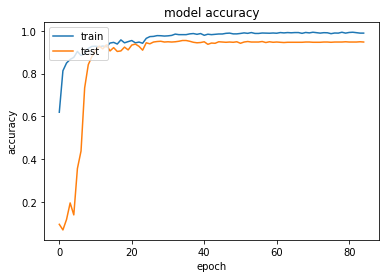

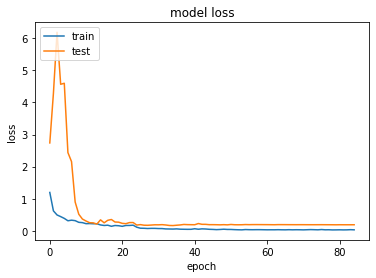

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 3s 1ms/sample - loss: 0.0109 - acc: 0.9949


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.49%
Accuracy on test set: 95.48%


In [24]:
Y_pred = model.predict(X_test_1)
if (n_classes == 14):
    labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']
else:
    labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

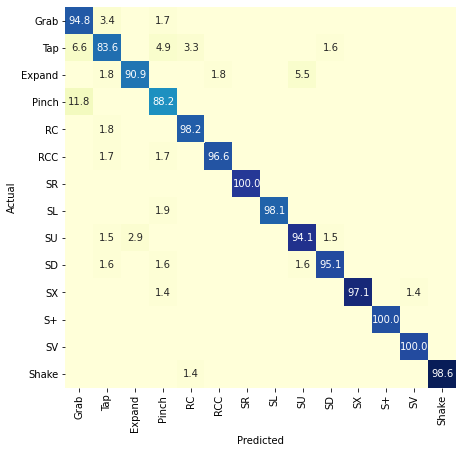

In [25]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

E:\Skelnet2D\SHREC\utils.py:83: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


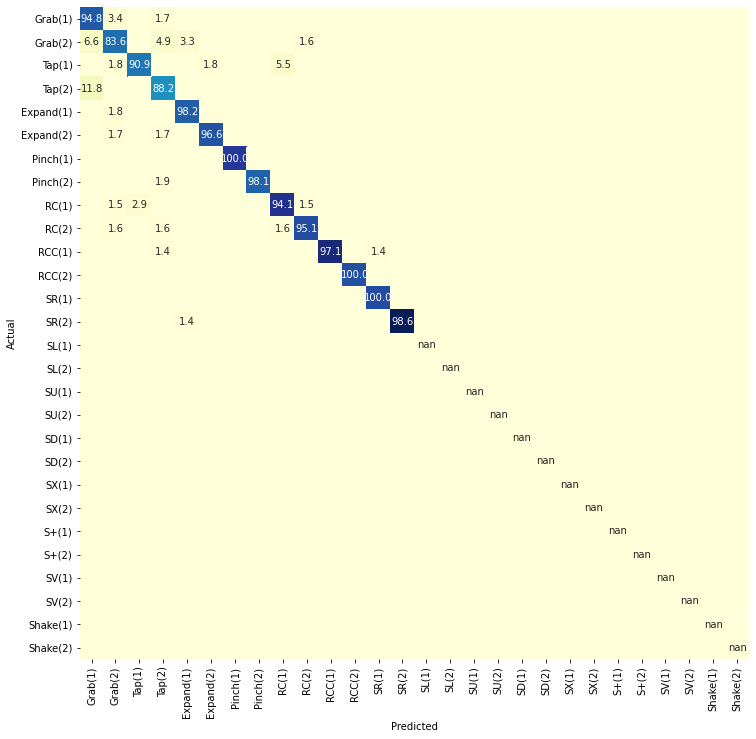